## Final Test-Set Evaluation Notebook
### Support Vector Machine Training Model

Based on cross-validation results in the optimization stages, Support Vector Machine was selected as the best model due to its performance:

* Training MSE: 0.2079
* Training R²: 0.9126

Other models showed significantly higher MSE and lower R² values.

In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')

# set random seed for reproducibility
np.random.seed(1234)


In [2]:
# load the data
X_train = pd.read_csv("../Data/X_train.csv")
y_train = pd.read_csv("../Data/y_train.csv")

X_test = pd.read_csv("../Data/X_test.csv")
y_test = pd.read_csv("../Data/y_test.csv")

print("Training data shape")
print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\n")
print("Test data shape")
print(f"X_test: {X_test.shape}\ny_test: {y_test.shape}\n")

print("First few rows of training data:")
display(X_test.head())


Training data shape
X_train: (400, 9)
y_train: (400, 1)

Test data shape
X_test: (100, 9)
y_test: (100, 1)

First few rows of training data:


,User_ID,Age,Gender,Daily_Screen_Time(hrs),Sleep_Quality(1-10),Stress_Level(1-10),Days_Without_Social_Media,Exercise_Frequency(week),Social_Media_Platform
0,U068,22,Male,5.2,9.0,7.0,5.0,1.0,TikTok
1,U417,46,Male,8.0,4.0,8.0,3.0,2.0,Facebook
2,U351,16,Other,7.3,5.0,9.0,0.0,2.0,Instagram
3,U359,47,Male,7.4,6.0,7.0,5.0,2.0,LinkedIn
4,U113,37,Female,4.3,6.0,8.0,3.0,5.0,LinkedIn


### Data Preprocessing

Utilizes ColumnTransformer to create a preprocessing step for our pipeline. Identifies categorical variables and uses OrdinalEncoder to process them. Drops applicable columns.

In [3]:
# preprocessing pipeline (drop id, encode categorical variables, scale numeric features)

# Drop User_ID
drop_cols = []
if 'User_ID' in X_train.columns:
    drop_cols.append('User_ID')

# Identify categorical and numeric features
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
print(f"Categorical features identified: {categorical_features}")
print(f"Numeric features identified: {numeric_features}")

preprocessor = ColumnTransformer(
    transformers=[
        #('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('categorical', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features),
        ('drop', 'drop', drop_cols),
        ('numeric', StandardScaler(), numeric_features)
    ], remainder='passthrough'
)

Categorical features identified: ['User_ID', 'Gender', 'Social_Media_Platform']
Numeric features identified: ['Age', 'Daily_Screen_Time(hrs)', 'Sleep_Quality(1-10)', 'Stress_Level(1-10)', 'Days_Without_Social_Media', 'Exercise_Frequency(week)']


### Model Setup

Creating a pipeline to execute preprocessing steps and model training with SVR, using the best_params from the earlier cross-validation results.

In [4]:
# insert best params from cross-validation

best_params = {
    'C': 10,
    'kernel': 'linear'
}


pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svr', SVR(**best_params))
])

print("Optimal hyperparameters from cross-validation:")
print(best_params)

Optimal hyperparameters from cross-validation:
{'C': 10, 'kernel': 'linear'}


### Model Training and Predictions on Training Set

Fitting the pipeline on the training data, then evaluating the model with training metrics. Follows the same steps as Ensemble.ipynb.

In [5]:
# initialize and train best model on training set

print("\nTraining final SVR model on entire training set...")

pipe.fit(X_train, y_train)

# Evaluate on training set (for reference)
y_train_pred = pipe.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

print("\nTraining set performance (for reference):")
print(f"  Mean Squared Error (MSE): {train_mse:.4f}")
print(f"  R-squared (R²): {train_r2:.4f}")
print(f"  Mean Absolute Error (MAE): {train_mae:.4f}")


Training final SVR model on entire training set...



Training set performance (for reference):
  Mean Squared Error (MSE): 0.8620
  R-squared (R²): 0.6377
  Mean Absolute Error (MAE): 0.7364


### Model Prediction Evaluation on Test Set

Makes predictions on the test data, and generates performance metrics.

In [6]:
# Make predictions on test set
y_test_pred = pipe.predict(X_test)

# Calculate evaluation metrics
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
residuals = y_test.squeeze() - y_test_pred

print("Test Set Evaluation Metrics:\n")
print(f"Mean Squared Error (MSE): {test_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {test_rmse:.4f}")
print(f"R-squared (R²): {test_r2:.4f}")
print(f"Mean Absolute Error (MAE): {test_mae:.4f}")

Test Set Evaluation Metrics:

Mean Squared Error (MSE): 0.7682
Root Mean Squared Error (RMSE): 0.8764
R-squared (R²): 0.6204
Mean Absolute Error (MAE): 0.7084


### Model Performance Analysis

Generates several plots and a summary table exploring the model's predictive power.
- Subplot 1: Scatterplot of Actual vs Predicted Values
- Subplot 2: Plot of Residuals
- Subplot 3: Histogram of the Distribution of the Residuals
- Final Model Evaluation: Outputs the best parameters, compares train and test metrics, and pulls out specific insights from the data

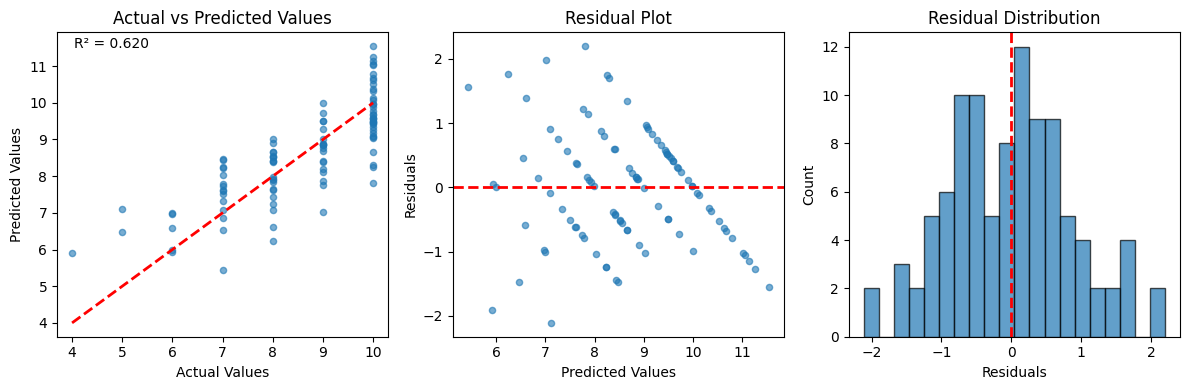

In [15]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# 1. Actual vs Predicted values (simple scatter)
axes[0].scatter(y_test, y_test_pred, alpha=0.6, s=20)
axes[0].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', lw=2)
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')
axes[0].set_title('Actual vs Predicted Values')
axes[0].text(0.05, 0.95, f'R² = {test_r2:.3f}', 
                transform=axes[0].transAxes, fontsize=10)

# 2. Residual plot (simple)
axes[1].scatter(y_test_pred, residuals, alpha=0.6, s=20)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')

# 3. Distribution of residuals (simple histogram)
axes[2].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
axes[2].axvline(x=0, color='r', linestyle='--', lw=2)
axes[2].set_xlabel('Residuals')
axes[2].set_ylabel('Count')
axes[2].set_title('Residual Distribution')

plt.tight_layout()
plt.savefig('../Outputs/final_test_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

In [16]:
# Create a summary table
summary_data = {
    'Metric': ['Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 
               'R-squared (R²)', 'Mean Absolute Error (MAE)'],
    'Training Set': [f'{train_mse:.4f}', f'{np.sqrt(train_mse):.4f}', 
                     f'{train_r2:.4f}', f'{train_mae:.4f}'],
    'Test Set': [f'{test_mse:.4f}', f'{test_rmse:.4f}', 
                 f'{test_r2:.4f}', f'{test_mae:.4f}']
}

summary_df = pd.DataFrame(summary_data)

print("FINAL MODEL EVALUATION: Support Vector Machine")
print("\nOptimal Hyperparameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

print("\nPerformance Comparison:")
print(summary_df.to_string(index=False))

print("\nKEY INSIGHTS:")
print(f"  Model explains {test_r2*100:.1f}% of variance (R² = {test_r2:.3f})")
print(f"  Test MSE ({test_mse:.3f}) vs Training MSE ({train_mse:.3f})")

FINAL MODEL EVALUATION: Support Vector Machine

Optimal Hyperparameters:
  C: 10
  kernel: linear

Performance Comparison:
                        Metric Training Set Test Set
      Mean Squared Error (MSE)       0.8620   0.7682
Root Mean Squared Error (RMSE)       0.9284   0.8764
                R-squared (R²)       0.6377   0.6204
     Mean Absolute Error (MAE)       0.7364   0.7084

KEY INSIGHTS:
  Model explains 62.0% of variance (R² = 0.620)
  Test MSE (0.768) vs Training MSE (0.862)


# needs revisiting - training metrics are off between this test and svm.ipynb
The explained variance of the model decreased significantly from _____% on training data to 62.04% on test data. The test MSE also worsened in comparison to the train MSE, with an increase from ______ to 0.7682. These metrics indicate substantial performance degradation on unseen data. The performance gap between train and test data suggests the model may be capturing dataset-specific patterns rather than generalizable relationships.